In [1]:
!pip install kaggle
!mkdir ~/.kaggle
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia
!kaggle datasets download -d tawsifurrahman/tuberculosis-tb-chest-xray-dataset

Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
100% 2.29G/2.29G [00:09<00:00, 282MB/s]
100% 2.29G/2.29G [00:09<00:00, 269MB/s]
Dataset URL: https://www.kaggle.com/datasets/tawsifurrahman/tuberculosis-tb-chest-xray-dataset
License(s): copyright-authors
 98% 650M/663M [00:04<00:00, 199MB/s]
100% 663M/663M [00:04<00:00, 149MB/s]


In [2]:
!unzip chest-xray-pneumonia.zip &> /dev/null
!unzip tuberculosis-tb-chest-xray-dataset.zip &> /dev/null

In [3]:
 !mv ./TB_Chest_Radiography_Database/Normal ./TB_Chest_Radiography_Database/NORMAL

In [4]:
!mv ./TB_Chest_Radiography_Database/Tuberculosis ./TB_Chest_Radiography_Database/TUBERCULOSIS

In [5]:
!rm ./TB_Chest_Radiography_Database/Normal.metadata.xlsx ./TB_Chest_Radiography_Database/README.md.txt ./TB_Chest_Radiography_Database/Tuberculosis.metadata.xlsx

In [6]:
data_chestxray_dir = "./chest_xray/chest_xray/"
data_chesttb_dir = "./TB_Chest_Radiography_Database/"

In [7]:
import os
import shutil
import random

# Paths to the original folders
classes_tbchest = ['NORMAL', 'TUBERCULOSIS']

# Paths for the new folders
base_dir_tbchest = 'chest_tb'
train_dir = os.path.join(base_dir_tbchest, 'train')
val_dir = os.path.join(base_dir_tbchest, 'val')
test_dir = os.path.join(base_dir_tbchest, 'test')

# Create directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

for cls in classes_tbchest:
    os.makedirs(os.path.join(train_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(val_dir, cls), exist_ok=True)
    os.makedirs(os.path.join(test_dir, cls), exist_ok=True)

# Split ratio
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15

# Function to split data
def split_data(class_dir, train_dir, val_dir, test_dir):
    files = os.listdir(class_dir)
    random.shuffle(files)

    train_size = int(len(files) * train_ratio)
    val_size = int(len(files) * val_ratio)

    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]

    for file in train_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(train_dir, file))

    for file in val_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(val_dir, file))

    for file in test_files:
        shutil.copy(os.path.join(class_dir, file), os.path.join(test_dir, file))

# Split each class
for cls in classes_tbchest:
    class_dir = os.path.join(data_chesttb_dir, cls)
    split_data(class_dir, os.path.join(train_dir, cls), os.path.join(val_dir, cls), os.path.join(test_dir, cls))

print("Dataset split completed!")

Dataset split completed!


In [8]:
data_chesttb_dir = "./chest_tb/"

In [9]:
from typing import Union
import torchvision.transforms as T
from PIL.Image import Image
from torch import Tensor
from typing import List, Optional, Tuple, Union


class SimCLRViewTransform:
    def __init__(
        self,
        image_size: int = 224,
        color_jitter_strength: float = 1,
        use_blur: bool = True,
        mean: Tuple[float, Optional[float], Optional[float]] = (0.485, 0.456, 0.406),
        std: Tuple[float, Optional[float], Optional[float]] = (0.229, 0.224, 0.225),
        **kwargs,
    ):
        self.image_size = image_size
        self.color_jitter_strength = color_jitter_strength
        self.use_blur = use_blur
        self.mean = mean
        self.std = std
        self.transform = T.Compose(
            [
                T.RandomResizedCrop(image_size, antialias=True),
                T.RandomHorizontalFlip(p=0.5),
                T.RandomApply(
                    [
                        T.ColorJitter(
                            0.8 * self.color_jitter_strength,
                            0.8 * self.color_jitter_strength,
                            0.8 * self.color_jitter_strength,
                            0.2 * self.color_jitter_strength,
                        )
                    ],
                    p=0.8,
                ),
                T.RandomGrayscale(p=0.2),
                T.RandomApply(
                    [
                        T.GaussianBlur(
                            kernel_size=image_size // 20 * 2 + 1, sigma=(0.1, 2.0)
                        )
                    ],
                    p=0.5 if self.use_blur else 0.0,
                ),
                T.Normalize(mean=mean, std=std),
            ]
        )

    def __call__(self, image: Union[Tensor, Image]) -> Tensor:
        return self.transform(image)

In [10]:
import os
from PIL import Image
import torch
import numpy as np
import torch.nn as nn
from torch.utils.data import Dataset
from torchvision import datasets, models, transforms


def data_transforms(phase):
    # If the phase is TRAIN
    if phase == 'train':
        # Compose transformations: Convert to Tensor
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
        ])

    # If the phase is VAL
    if phase == 'val':
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    # If the phase is TEST
    if phase == 'test':
        # Apply the same transformations as the TRAIN phase
        transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])

    return transform  # Return the composed transformations

image_datasets_chestxray = {x: datasets.ImageFolder(os.path.join(data_chestxray_dir, x), data_transforms(x)) for x in ['train', 'val', 'test']}
image_datasets_chesttb = {x: datasets.ImageFolder(os.path.join(data_chesttb_dir, x), data_transforms(x)) for x in ['train', 'val', 'test']}

new_class_to_idx_tb = {'NORMAL': 0, 'TUBERCULOSIS': 2}

# Function to remap the labels in a dataset
def remap_labels(dataset, new_class_to_idx):
    # Remap the targets
    dataset.targets = [new_class_to_idx[dataset.classes[label]] for label in dataset.targets]

    # Update class index in dataset.samples
    new_samples = []
    for path, label in dataset.samples:
        new_samples.append((path, new_class_to_idx[dataset.classes[label]]))
    dataset.samples = new_samples

    # Update the class_to_idx attribute
    dataset.class_to_idx = new_class_to_idx
    # Update the classes attribute
    dataset.classes = list(new_class_to_idx.keys())

# Apply the remapping to the chesttb datasets
for phase in ['train', 'val', 'test']:
    remap_labels(image_datasets_chesttb[phase], new_class_to_idx_tb)

In [11]:
print(image_datasets_chestxray['train'].class_to_idx)
print(len(image_datasets_chestxray['train']))

print(np.unique(image_datasets_chestxray['train'].targets, return_counts=True))

{'NORMAL': 0, 'PNEUMONIA': 1}
5216
(array([0, 1]), array([1341, 3875]))


In [12]:
print(image_datasets_chesttb['train'].class_to_idx)
print(len(image_datasets_chesttb['train']))

print(np.unique(image_datasets_chesttb['train'].targets, return_counts=True))

{'NORMAL': 0, 'TUBERCULOSIS': 2}
2939
(array([0, 2]), array([2450,  489]))


In [13]:
# Combine the datasets after remapping
image_datasets_combined = {
    x: torch.utils.data.ConcatDataset([image_datasets_chestxray[x], image_datasets_chesttb[x]])
    for x in ['train', 'val', 'test']
}

In [14]:
targets_combined = []

for dataset in image_datasets_combined['train'].datasets:
    targets_combined.extend(dataset.targets)

targets_combined = torch.tensor(targets_combined)

# Calculate class weights (inverse of class frequency)
class_counts = torch.bincount(targets_combined)
class_weights = 1.0 / class_counts.float()
print(f"Class weights: {class_weights}")

# Calculate sample weights based on class weights
sample_weights = class_weights[targets_combined]
print(f"Sample weights: {sample_weights}")

# Create WeightedRandomSampler
sampler = torch.utils.data.WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

Class weights: tensor([0.0003, 0.0003, 0.0020])
Sample weights: tensor([0.0003, 0.0003, 0.0003,  ..., 0.0020, 0.0020, 0.0020])


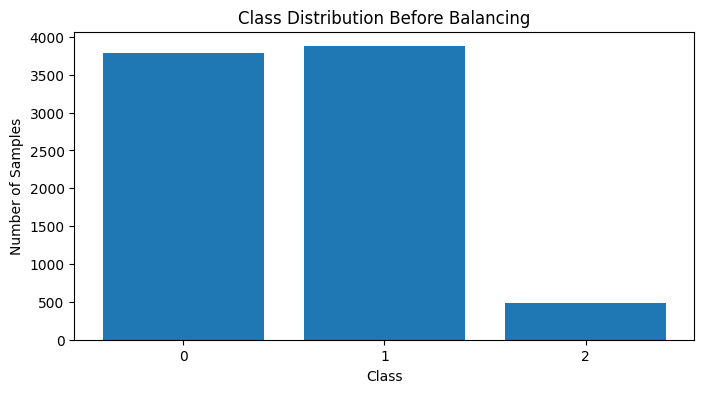

Class counts before balancing: [3791 3875  489]


In [15]:
import matplotlib.pyplot as plt

# Count the number of instances of each class before balancing
class_counts = torch.bincount(targets_combined)

# Plot the class distribution
plt.figure(figsize=(8, 4))
plt.bar(range(len(class_counts)), class_counts.numpy(), tick_label=list(range(len(class_counts))))
plt.title("Class Distribution Before Balancing")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

print("Class counts before balancing:", class_counts.numpy())

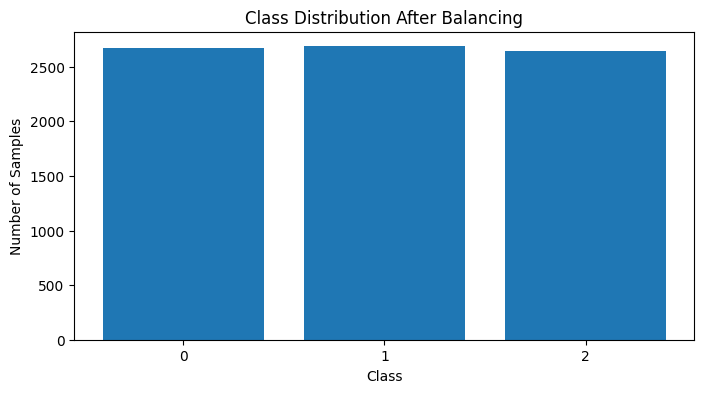

Class counts after balancing: [2673 2686 2641]


In [16]:
# Simulate sampling
num_samples_to_check = 8000  # You can increase this number for better accuracy
sampled_indices = list(sampler)[:num_samples_to_check]
sampled_targets = targets_combined[sampled_indices]

# Count the number of instances of each class after balancing
balanced_class_counts = torch.bincount(sampled_targets)

# Plot the class distribution after balancing
plt.figure(figsize=(8, 4))
plt.bar(range(len(balanced_class_counts)), balanced_class_counts.numpy(), tick_label=list(range(len(balanced_class_counts))))
plt.title("Class Distribution After Balancing")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.show()

print("Class counts after balancing:", balanced_class_counts.numpy())

In [17]:
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets_combined['train'], batch_size = 32, sampler=sampler),
    'val': torch.utils.data.DataLoader(image_datasets_combined['val'], batch_size = 32),
    'test': torch.utils.data.DataLoader(image_datasets_combined['test'], batch_size = 32)
}

In [18]:
len(dataloaders['train'])

255

In [19]:
import torch.nn.functional as F
class BarlowTwinsLoss(nn.Module):
    def __init__(self, lambda_param: float = 5e-3, **kwargs):
        super(BarlowTwinsLoss, self).__init__()
        self.lambda_param = lambda_param

    def off_diagonal(self, x):
        # return a flattened view of the off-diagonal elements of a square matrix
        n, m = x.shape
        assert n == m
        return x.flatten()[:-1].view(n - 1, n + 1)[:, 1:].flatten()

    def forward(self, z_a: torch.Tensor, z_b: torch.Tensor):
        # normalize repr. along the batch dimension
        z_a = F.normalize(z_a, dim=-1)
        z_b = F.normalize(z_b, dim=-1)
        # normalize the representations along the batch dimension
        out_1_norm = (z_a - z_a.mean(dim=0)) / z_a.std(dim=0)
        out_2_norm = (z_b - z_b.mean(dim=0)) / z_b.std(dim=0)

        # cross-correlation matrix
        batch_size = z_a.size(0)
        c = torch.matmul(out_1_norm.T, out_2_norm) / batch_size

        # loss
        on_diag = torch.diagonal(c).add_(-1).pow_(2).sum()
        off_diag = self.off_diagonal(c).add_(1).pow_(2).sum()
        loss = on_diag + self.lambda_param * off_diag

        return loss

In [20]:
class BarlowTwins(nn.Module):

    def __init__(
        self,
        backbone: nn.Module,
        feature_size: int,
        projection_dim: int = 8192,
        hidden_dim: int = 8192,
        **kwargs
    ):
        super().__init__()
        self.feature_size = feature_size
        self.projection_dim = projection_dim
        self.hidden_dim = hidden_dim
        self.backbone = backbone

        self.projection_head = nn.Sequential(
            nn.Sequential(nn.Linear(self.feature_size, self.hidden_dim), nn.BatchNorm1d(self.hidden_dim), nn.ReLU(inplace=True)),
            nn.Sequential(nn.Linear(self.hidden_dim, self.hidden_dim), nn.BatchNorm1d(self.hidden_dim), nn.ReLU(inplace=True)),
            nn.Sequential(nn.Linear(self.hidden_dim, self.projection_dim)))

        self.encoder = nn.Sequential(self.backbone, self.projection_head)

    def forward(self, x0: torch.Tensor, x1: torch.Tensor):
        f0 = self.backbone(x0).flatten(start_dim=1)
        out0 = self.projection_head(f0)

        f1 = self.backbone(x1).flatten(start_dim=1)
        out1 = self.projection_head(f1)

        return out0, out1

In [21]:
backbone = models.resnet50()
num_features = backbone.fc.in_features
backbone.fc = nn.Identity()
model = BarlowTwins(backbone=backbone, feature_size=num_features, projection_dim=128)

# # Replace the backbone's classifier with a new linear layer
# num_classes = 3  # Number of classes in your dataset
# model.backbone.fc = nn.Linear(num_features, num_classes)
# model = model.backbone.to(device)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [22]:
print(f"Number of Model Parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Memmory Usage: {torch.cuda.memory_allocated(device) / 1024**3:.2f} GB")

Number of Model Parameters: 108491968
Memmory Usage: 0.40 GB


In [23]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
criterion = BarlowTwinsLoss()
ssl_transform = SimCLRViewTransform()

### SSL training

In [24]:
import torch
import numpy as np
import pickle
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Load existing metrics if the file exists
metrics_file_path = "/content/drive/MyDrive/training_metrics_ssl_Barlow_training.pkl"

try:
    with open(metrics_file_path, 'rb') as f:
        metrics = pickle.load(f)
        print("Loaded existing metrics.")
except FileNotFoundError:
    metrics = {'train_loss': [], 'val_loss': []}
    print("No existing metrics found. Starting fresh.")

# Parameters for Early Stopping
early_stopping_patience = 5  # Stop after 5 epochs with no improvement
best_val_loss = float('inf')
patience_counter = 0

num_epochs = 100  # Set a higher number of epochs to allow early stopping

model.load_state_dict(torch.load('/content/drive/MyDrive/model_ssl_Barlow_epoch_100.pth'))

for epoch in range(100,num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)
    # Each epoch has a training and validation phase
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()  # Set model to training mode
            dataloader = dataloaders['train']
        else:
            model.eval()  # Set model to evaluate mode
            dataloader = dataloaders['val']

        running_loss = 0.0

        # Iterate over data with tqdm progress bar
        for inputs, _ in tqdm(dataloader, desc=f"{phase.capitalize()} Phase"):
            inputs = inputs.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            aug1 = ssl_transform(inputs)
            aug2 = ssl_transform(inputs)

            # Forward pass
            with torch.set_grad_enabled(phase == 'train'):
                out0, out1 = model(aug1, aug2)
                loss = criterion(out0, out1)

                # Backward pass + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            # Statistics
            running_loss += loss.item() * inputs.size(0)

        # Calculate metrics
        epoch_loss = running_loss / len(dataloader.dataset)

        # Save metrics
        metrics[f'{phase}_loss'].append(epoch_loss)

        print(f'{phase.capitalize()} Loss: {epoch_loss:.4f}')

        # Early stopping check during validation phase
        if phase == 'val':
            if epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                patience_counter = 0  # Reset the counter if improvement occurs
                # Save the model weights when improvement occurs
                torch.save(model.state_dict(), '/content/drive/MyDrive/best_model_ssl_barlowTwins_training.pth')
            else:
                patience_counter += 1

        if (epoch+1) % 10 == 0:
            # Save the model weights every 10 epochs
            torch.save(model.state_dict(), f'/content/drive/MyDrive/model_ssl_Barlow_epoch_{epoch+1}.pth')
            # Save the metrics to the pickle file
            with open(metrics_file_path, 'wb') as f:
                pickle.dump(metrics, f)
            print(f"Metrics saved at epoch {epoch}.")

    print()

print(f"Final metrics saved to {metrics_file_path}")


Mounted at /content/drive
Loaded existing metrics.
Final metrics saved to /content/drive/MyDrive/training_metrics_ssl_Barlow_training.pkl


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


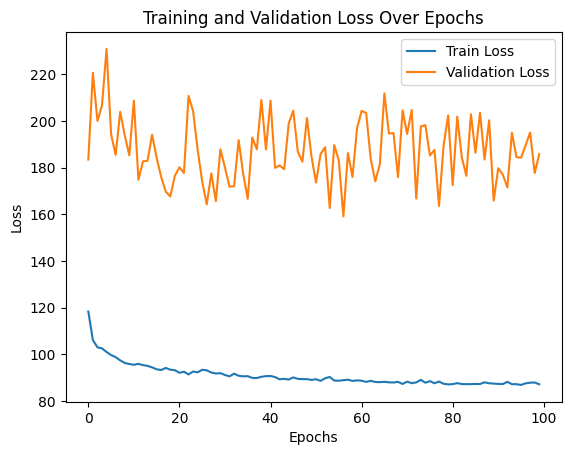

In [25]:
import pickle
import matplotlib.pyplot as plt
from google.colab import drive
drive.mount('/content/drive')

metrics_file_path = "/content/drive/MyDrive/training_metrics_ssl_Barlow_training.pkl"



with open(metrics_file_path, 'rb') as f:
    metrics = pickle.load(f)

# Plotting the metrics
plt.plot(metrics['train_loss'], label='Train Loss')
plt.plot(metrics['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score
from tqdm import tqdm

# Freeze the backbone
for param in model.backbone.parameters():
    param.requires_grad = True

# Replace the backbone's classifier with a new linear layer
num_classes = 3  # Number of classes in your dataset
# num_features = model.backbone.fc.in_features  # Adjust this according to your model
model.backbone.fc = nn.Linear(num_features, num_classes)
model = model.backbone.to(device)

# Define loss function and optimizer for the linear classifier
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

# Metrics storage
train_losses = []
train_accuracies = []
train_precisions = []
train_recalls = []
train_f1_scores = []

num_epochs_linear = 100  # Adjust as needed

for epoch in range(num_epochs_linear):
    model.train()
    running_loss = 0.0
    running_corrects = 0

    # For calculating precision, recall, and F1
    all_labels = []
    all_preds = []

    for inputs, labels in tqdm(dataloaders['train'], desc=f"Linear Eval Epoch {epoch+1}"):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

        # Store predictions and labels for metric calculations
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

    epoch_loss = running_loss / len(dataloaders['train'].dataset)
    epoch_acc = running_corrects.double() / len(dataloaders['train'].dataset)

    # Calculate precision, recall, and F1-score
    epoch_precision = precision_score(all_labels, all_preds, average='weighted')
    epoch_recall = recall_score(all_labels, all_preds, average='weighted')
    epoch_f1 = f1_score(all_labels, all_preds, average='weighted')

    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())
    train_precisions.append(epoch_precision)
    train_recalls.append(epoch_recall)
    train_f1_scores.append(epoch_f1)

    print(f"Linear Eval Epoch {epoch+1} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Precision: {epoch_precision:.4f} Recall: {epoch_recall:.4f} F1-Score: {epoch_f1:.4f}")


Linear Eval Epoch 1: 100%|██████████| 255/255 [02:29<00:00,  1.70it/s]


Linear Eval Epoch 1 Loss: 0.2829 Acc: 0.8909 Precision: 0.8912 Recall: 0.8909 F1-Score: 0.8910


Linear Eval Epoch 2: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


Linear Eval Epoch 2 Loss: 0.2249 Acc: 0.9153 Precision: 0.9154 Recall: 0.9153 F1-Score: 0.9153


Linear Eval Epoch 3: 100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


Linear Eval Epoch 3 Loss: 0.1868 Acc: 0.9277 Precision: 0.9278 Recall: 0.9277 F1-Score: 0.9277


Linear Eval Epoch 4: 100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


Linear Eval Epoch 4 Loss: 0.1833 Acc: 0.9286 Precision: 0.9287 Recall: 0.9286 F1-Score: 0.9287


Linear Eval Epoch 5: 100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


Linear Eval Epoch 5 Loss: 0.1699 Acc: 0.9360 Precision: 0.9361 Recall: 0.9360 F1-Score: 0.9360


Linear Eval Epoch 6: 100%|██████████| 255/255 [02:24<00:00,  1.77it/s]


Linear Eval Epoch 6 Loss: 0.1653 Acc: 0.9393 Precision: 0.9393 Recall: 0.9393 F1-Score: 0.9393


Linear Eval Epoch 7: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 7 Loss: 0.1552 Acc: 0.9415 Precision: 0.9416 Recall: 0.9415 F1-Score: 0.9416


Linear Eval Epoch 8: 100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


Linear Eval Epoch 8 Loss: 0.1654 Acc: 0.9395 Precision: 0.9396 Recall: 0.9395 F1-Score: 0.9396


Linear Eval Epoch 9: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


Linear Eval Epoch 9 Loss: 0.1365 Acc: 0.9490 Precision: 0.9490 Recall: 0.9490 F1-Score: 0.9490


Linear Eval Epoch 10: 100%|██████████| 255/255 [02:24<00:00,  1.77it/s]


Linear Eval Epoch 10 Loss: 0.1561 Acc: 0.9414 Precision: 0.9414 Recall: 0.9414 F1-Score: 0.9414


Linear Eval Epoch 11: 100%|██████████| 255/255 [02:25<00:00,  1.76it/s]


Linear Eval Epoch 11 Loss: 0.1359 Acc: 0.9514 Precision: 0.9515 Recall: 0.9514 F1-Score: 0.9515


Linear Eval Epoch 12: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 12 Loss: 0.1306 Acc: 0.9527 Precision: 0.9527 Recall: 0.9527 F1-Score: 0.9527


Linear Eval Epoch 13: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 13 Loss: 0.1308 Acc: 0.9506 Precision: 0.9506 Recall: 0.9506 F1-Score: 0.9506


Linear Eval Epoch 14: 100%|██████████| 255/255 [02:24<00:00,  1.77it/s]


Linear Eval Epoch 14 Loss: 0.1296 Acc: 0.9541 Precision: 0.9541 Recall: 0.9541 F1-Score: 0.9541


Linear Eval Epoch 15: 100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


Linear Eval Epoch 15 Loss: 0.1186 Acc: 0.9566 Precision: 0.9567 Recall: 0.9566 F1-Score: 0.9566


Linear Eval Epoch 16: 100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


Linear Eval Epoch 16 Loss: 0.1222 Acc: 0.9550 Precision: 0.9550 Recall: 0.9550 F1-Score: 0.9550


Linear Eval Epoch 17: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 17 Loss: 0.1037 Acc: 0.9639 Precision: 0.9640 Recall: 0.9639 F1-Score: 0.9640


Linear Eval Epoch 18: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 18 Loss: 0.1139 Acc: 0.9578 Precision: 0.9579 Recall: 0.9578 F1-Score: 0.9578


Linear Eval Epoch 19: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 19 Loss: 0.1238 Acc: 0.9559 Precision: 0.9559 Recall: 0.9559 F1-Score: 0.9559


Linear Eval Epoch 20: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 20 Loss: 0.1209 Acc: 0.9561 Precision: 0.9562 Recall: 0.9561 F1-Score: 0.9561


Linear Eval Epoch 21: 100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


Linear Eval Epoch 21 Loss: 0.1171 Acc: 0.9551 Precision: 0.9551 Recall: 0.9551 F1-Score: 0.9551


Linear Eval Epoch 22: 100%|██████████| 255/255 [02:24<00:00,  1.77it/s]


Linear Eval Epoch 22 Loss: 0.1278 Acc: 0.9539 Precision: 0.9539 Recall: 0.9539 F1-Score: 0.9539


Linear Eval Epoch 23: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 23 Loss: 0.1168 Acc: 0.9565 Precision: 0.9565 Recall: 0.9565 F1-Score: 0.9565


Linear Eval Epoch 24: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


Linear Eval Epoch 24 Loss: 0.1023 Acc: 0.9609 Precision: 0.9609 Recall: 0.9609 F1-Score: 0.9609


Linear Eval Epoch 25: 100%|██████████| 255/255 [02:26<00:00,  1.75it/s]


Linear Eval Epoch 25 Loss: 0.1093 Acc: 0.9589 Precision: 0.9590 Recall: 0.9589 F1-Score: 0.9589


Linear Eval Epoch 26: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 26 Loss: 0.1256 Acc: 0.9546 Precision: 0.9546 Recall: 0.9546 F1-Score: 0.9546


Linear Eval Epoch 27: 100%|██████████| 255/255 [02:25<00:00,  1.76it/s]


Linear Eval Epoch 27 Loss: 0.1201 Acc: 0.9538 Precision: 0.9538 Recall: 0.9538 F1-Score: 0.9538


Linear Eval Epoch 28: 100%|██████████| 255/255 [02:24<00:00,  1.77it/s]


Linear Eval Epoch 28 Loss: 0.0951 Acc: 0.9660 Precision: 0.9660 Recall: 0.9660 F1-Score: 0.9660


Linear Eval Epoch 29: 100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


Linear Eval Epoch 29 Loss: 0.1106 Acc: 0.9611 Precision: 0.9612 Recall: 0.9611 F1-Score: 0.9611


Linear Eval Epoch 30: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 30 Loss: 0.1126 Acc: 0.9600 Precision: 0.9600 Recall: 0.9600 F1-Score: 0.9600


Linear Eval Epoch 31: 100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


Linear Eval Epoch 31 Loss: 0.0928 Acc: 0.9675 Precision: 0.9675 Recall: 0.9675 F1-Score: 0.9675


Linear Eval Epoch 32: 100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


Linear Eval Epoch 32 Loss: 0.1262 Acc: 0.9562 Precision: 0.9562 Recall: 0.9562 F1-Score: 0.9562


Linear Eval Epoch 33: 100%|██████████| 255/255 [02:25<00:00,  1.76it/s]


Linear Eval Epoch 33 Loss: 0.1075 Acc: 0.9617 Precision: 0.9618 Recall: 0.9617 F1-Score: 0.9618


Linear Eval Epoch 34: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


Linear Eval Epoch 34 Loss: 0.0827 Acc: 0.9700 Precision: 0.9700 Recall: 0.9700 F1-Score: 0.9700


Linear Eval Epoch 35: 100%|██████████| 255/255 [02:25<00:00,  1.76it/s]


Linear Eval Epoch 35 Loss: 0.0928 Acc: 0.9682 Precision: 0.9682 Recall: 0.9682 F1-Score: 0.9682


Linear Eval Epoch 36: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 36 Loss: 0.1038 Acc: 0.9622 Precision: 0.9623 Recall: 0.9622 F1-Score: 0.9623


Linear Eval Epoch 37: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 37 Loss: 0.0986 Acc: 0.9647 Precision: 0.9647 Recall: 0.9647 F1-Score: 0.9647


Linear Eval Epoch 38: 100%|██████████| 255/255 [02:25<00:00,  1.76it/s]


Linear Eval Epoch 38 Loss: 0.0991 Acc: 0.9652 Precision: 0.9652 Recall: 0.9652 F1-Score: 0.9652


Linear Eval Epoch 39: 100%|██████████| 255/255 [02:23<00:00,  1.77it/s]


Linear Eval Epoch 39 Loss: 0.0961 Acc: 0.9649 Precision: 0.9650 Recall: 0.9649 F1-Score: 0.9649


Linear Eval Epoch 40: 100%|██████████| 255/255 [02:25<00:00,  1.76it/s]


Linear Eval Epoch 40 Loss: 0.1045 Acc: 0.9628 Precision: 0.9628 Recall: 0.9628 F1-Score: 0.9628


Linear Eval Epoch 41: 100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


Linear Eval Epoch 41 Loss: 0.0955 Acc: 0.9677 Precision: 0.9678 Recall: 0.9677 F1-Score: 0.9678


Linear Eval Epoch 42: 100%|██████████| 255/255 [02:23<00:00,  1.77it/s]


Linear Eval Epoch 42 Loss: 0.1058 Acc: 0.9635 Precision: 0.9634 Recall: 0.9635 F1-Score: 0.9634


Linear Eval Epoch 43: 100%|██████████| 255/255 [02:25<00:00,  1.76it/s]


Linear Eval Epoch 43 Loss: 0.1060 Acc: 0.9637 Precision: 0.9637 Recall: 0.9637 F1-Score: 0.9637


Linear Eval Epoch 44: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 44 Loss: 0.0888 Acc: 0.9689 Precision: 0.9688 Recall: 0.9689 F1-Score: 0.9688


Linear Eval Epoch 45: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 45 Loss: 0.0790 Acc: 0.9712 Precision: 0.9712 Recall: 0.9712 F1-Score: 0.9712


Linear Eval Epoch 46: 100%|██████████| 255/255 [02:23<00:00,  1.78it/s]


Linear Eval Epoch 46 Loss: 0.1156 Acc: 0.9628 Precision: 0.9628 Recall: 0.9628 F1-Score: 0.9628


Linear Eval Epoch 47: 100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


Linear Eval Epoch 47 Loss: 0.0919 Acc: 0.9682 Precision: 0.9683 Recall: 0.9682 F1-Score: 0.9682


Linear Eval Epoch 48: 100%|██████████| 255/255 [02:24<00:00,  1.77it/s]


Linear Eval Epoch 48 Loss: 0.0831 Acc: 0.9702 Precision: 0.9702 Recall: 0.9702 F1-Score: 0.9702


Linear Eval Epoch 49: 100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


Linear Eval Epoch 49 Loss: 0.0860 Acc: 0.9695 Precision: 0.9695 Recall: 0.9695 F1-Score: 0.9695


Linear Eval Epoch 50: 100%|██████████| 255/255 [02:24<00:00,  1.77it/s]


Linear Eval Epoch 50 Loss: 0.0843 Acc: 0.9704 Precision: 0.9704 Recall: 0.9704 F1-Score: 0.9704


Linear Eval Epoch 51: 100%|██████████| 255/255 [02:24<00:00,  1.77it/s]


Linear Eval Epoch 51 Loss: 0.0847 Acc: 0.9690 Precision: 0.9690 Recall: 0.9690 F1-Score: 0.9690


Linear Eval Epoch 52: 100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


Linear Eval Epoch 52 Loss: 0.0921 Acc: 0.9671 Precision: 0.9672 Recall: 0.9671 F1-Score: 0.9671


Linear Eval Epoch 53: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 53 Loss: 0.0804 Acc: 0.9724 Precision: 0.9724 Recall: 0.9724 F1-Score: 0.9724


Linear Eval Epoch 54: 100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


Linear Eval Epoch 54 Loss: 0.1098 Acc: 0.9604 Precision: 0.9604 Recall: 0.9604 F1-Score: 0.9604


Linear Eval Epoch 55: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 55 Loss: 0.1054 Acc: 0.9609 Precision: 0.9609 Recall: 0.9609 F1-Score: 0.9609


Linear Eval Epoch 56: 100%|██████████| 255/255 [02:24<00:00,  1.77it/s]


Linear Eval Epoch 56 Loss: 0.1048 Acc: 0.9664 Precision: 0.9664 Recall: 0.9664 F1-Score: 0.9664


Linear Eval Epoch 57: 100%|██████████| 255/255 [02:24<00:00,  1.77it/s]


Linear Eval Epoch 57 Loss: 0.0737 Acc: 0.9752 Precision: 0.9752 Recall: 0.9752 F1-Score: 0.9752


Linear Eval Epoch 58: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


Linear Eval Epoch 58 Loss: 0.0669 Acc: 0.9755 Precision: 0.9755 Recall: 0.9755 F1-Score: 0.9755


Linear Eval Epoch 59: 100%|██████████| 255/255 [02:23<00:00,  1.78it/s]


Linear Eval Epoch 59 Loss: 0.0865 Acc: 0.9695 Precision: 0.9695 Recall: 0.9695 F1-Score: 0.9695


Linear Eval Epoch 60: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


Linear Eval Epoch 60 Loss: 0.1037 Acc: 0.9648 Precision: 0.9648 Recall: 0.9648 F1-Score: 0.9648


Linear Eval Epoch 61: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


Linear Eval Epoch 61 Loss: 0.0827 Acc: 0.9696 Precision: 0.9696 Recall: 0.9696 F1-Score: 0.9696


Linear Eval Epoch 62: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 62 Loss: 0.0894 Acc: 0.9693 Precision: 0.9694 Recall: 0.9693 F1-Score: 0.9693


Linear Eval Epoch 63: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


Linear Eval Epoch 63 Loss: 0.0906 Acc: 0.9695 Precision: 0.9695 Recall: 0.9695 F1-Score: 0.9695


Linear Eval Epoch 64: 100%|██████████| 255/255 [02:26<00:00,  1.75it/s]


Linear Eval Epoch 64 Loss: 0.0591 Acc: 0.9783 Precision: 0.9783 Recall: 0.9783 F1-Score: 0.9783


Linear Eval Epoch 65: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 65 Loss: 0.0875 Acc: 0.9701 Precision: 0.9701 Recall: 0.9701 F1-Score: 0.9701


Linear Eval Epoch 66: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 66 Loss: 0.0835 Acc: 0.9686 Precision: 0.9686 Recall: 0.9686 F1-Score: 0.9686


Linear Eval Epoch 67: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


Linear Eval Epoch 67 Loss: 0.0581 Acc: 0.9783 Precision: 0.9783 Recall: 0.9783 F1-Score: 0.9783


Linear Eval Epoch 68: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


Linear Eval Epoch 68 Loss: 0.0735 Acc: 0.9730 Precision: 0.9731 Recall: 0.9730 F1-Score: 0.9730


Linear Eval Epoch 69: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


Linear Eval Epoch 69 Loss: 0.0796 Acc: 0.9713 Precision: 0.9713 Recall: 0.9713 F1-Score: 0.9713


Linear Eval Epoch 70: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 70 Loss: 0.0775 Acc: 0.9712 Precision: 0.9712 Recall: 0.9712 F1-Score: 0.9712


Linear Eval Epoch 71: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 71 Loss: 0.0847 Acc: 0.9711 Precision: 0.9711 Recall: 0.9711 F1-Score: 0.9711


Linear Eval Epoch 72: 100%|██████████| 255/255 [02:26<00:00,  1.73it/s]


Linear Eval Epoch 72 Loss: 0.0731 Acc: 0.9740 Precision: 0.9740 Recall: 0.9740 F1-Score: 0.9740


Linear Eval Epoch 73: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 73 Loss: 0.0900 Acc: 0.9674 Precision: 0.9674 Recall: 0.9674 F1-Score: 0.9674


Linear Eval Epoch 74: 100%|██████████| 255/255 [02:25<00:00,  1.76it/s]


Linear Eval Epoch 74 Loss: 0.0891 Acc: 0.9690 Precision: 0.9690 Recall: 0.9690 F1-Score: 0.9690


Linear Eval Epoch 75: 100%|██████████| 255/255 [02:25<00:00,  1.76it/s]


Linear Eval Epoch 75 Loss: 0.0707 Acc: 0.9734 Precision: 0.9734 Recall: 0.9734 F1-Score: 0.9734


Linear Eval Epoch 76: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 76 Loss: 0.0829 Acc: 0.9693 Precision: 0.9694 Recall: 0.9693 F1-Score: 0.9694


Linear Eval Epoch 77: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 77 Loss: 0.0712 Acc: 0.9752 Precision: 0.9752 Recall: 0.9752 F1-Score: 0.9752


Linear Eval Epoch 78: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


Linear Eval Epoch 78 Loss: 0.1154 Acc: 0.9622 Precision: 0.9622 Recall: 0.9622 F1-Score: 0.9622


Linear Eval Epoch 79: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


Linear Eval Epoch 79 Loss: 0.0628 Acc: 0.9773 Precision: 0.9773 Recall: 0.9773 F1-Score: 0.9773


Linear Eval Epoch 80: 100%|██████████| 255/255 [02:26<00:00,  1.75it/s]


Linear Eval Epoch 80 Loss: 0.0595 Acc: 0.9790 Precision: 0.9790 Recall: 0.9790 F1-Score: 0.9790


Linear Eval Epoch 81: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 81 Loss: 0.0991 Acc: 0.9653 Precision: 0.9653 Recall: 0.9653 F1-Score: 0.9653


Linear Eval Epoch 82: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


Linear Eval Epoch 82 Loss: 0.0672 Acc: 0.9738 Precision: 0.9738 Recall: 0.9738 F1-Score: 0.9738


Linear Eval Epoch 83: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 83 Loss: 0.0856 Acc: 0.9697 Precision: 0.9697 Recall: 0.9697 F1-Score: 0.9697


Linear Eval Epoch 84: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 84 Loss: 0.0714 Acc: 0.9750 Precision: 0.9750 Recall: 0.9750 F1-Score: 0.9750


Linear Eval Epoch 85: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


Linear Eval Epoch 85 Loss: 0.0818 Acc: 0.9709 Precision: 0.9710 Recall: 0.9709 F1-Score: 0.9709


Linear Eval Epoch 86: 100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


Linear Eval Epoch 86 Loss: 0.0730 Acc: 0.9746 Precision: 0.9746 Recall: 0.9746 F1-Score: 0.9746


Linear Eval Epoch 87: 100%|██████████| 255/255 [02:25<00:00,  1.76it/s]


Linear Eval Epoch 87 Loss: 0.0779 Acc: 0.9719 Precision: 0.9719 Recall: 0.9719 F1-Score: 0.9719


Linear Eval Epoch 88: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 88 Loss: 0.0665 Acc: 0.9750 Precision: 0.9750 Recall: 0.9750 F1-Score: 0.9750


Linear Eval Epoch 89: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


Linear Eval Epoch 89 Loss: 0.0723 Acc: 0.9756 Precision: 0.9756 Recall: 0.9756 F1-Score: 0.9756


Linear Eval Epoch 90: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 90 Loss: 0.0728 Acc: 0.9742 Precision: 0.9742 Recall: 0.9742 F1-Score: 0.9742


Linear Eval Epoch 91: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 91 Loss: 0.0646 Acc: 0.9772 Precision: 0.9772 Recall: 0.9772 F1-Score: 0.9772


Linear Eval Epoch 92: 100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


Linear Eval Epoch 92 Loss: 0.0792 Acc: 0.9709 Precision: 0.9710 Recall: 0.9709 F1-Score: 0.9710


Linear Eval Epoch 93: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


Linear Eval Epoch 93 Loss: 0.0981 Acc: 0.9652 Precision: 0.9652 Recall: 0.9652 F1-Score: 0.9652


Linear Eval Epoch 94: 100%|██████████| 255/255 [02:26<00:00,  1.75it/s]


Linear Eval Epoch 94 Loss: 0.0721 Acc: 0.9739 Precision: 0.9739 Recall: 0.9739 F1-Score: 0.9739


Linear Eval Epoch 95: 100%|██████████| 255/255 [02:24<00:00,  1.76it/s]


Linear Eval Epoch 95 Loss: 0.0544 Acc: 0.9806 Precision: 0.9806 Recall: 0.9806 F1-Score: 0.9806


Linear Eval Epoch 96: 100%|██████████| 255/255 [02:25<00:00,  1.75it/s]


Linear Eval Epoch 96 Loss: 0.0612 Acc: 0.9783 Precision: 0.9783 Recall: 0.9783 F1-Score: 0.9783


Linear Eval Epoch 97: 100%|██████████| 255/255 [02:25<00:00,  1.76it/s]


Linear Eval Epoch 97 Loss: 0.0597 Acc: 0.9787 Precision: 0.9787 Recall: 0.9787 F1-Score: 0.9787


Linear Eval Epoch 98: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]


Linear Eval Epoch 98 Loss: 0.0647 Acc: 0.9772 Precision: 0.9772 Recall: 0.9772 F1-Score: 0.9772


Linear Eval Epoch 99: 100%|██████████| 255/255 [02:26<00:00,  1.75it/s]


Linear Eval Epoch 99 Loss: 0.0744 Acc: 0.9741 Precision: 0.9741 Recall: 0.9741 F1-Score: 0.9741


Linear Eval Epoch 100: 100%|██████████| 255/255 [02:26<00:00,  1.74it/s]

Linear Eval Epoch 100 Loss: 0.0610 Acc: 0.9785 Precision: 0.9785 Recall: 0.9785 F1-Score: 0.9785


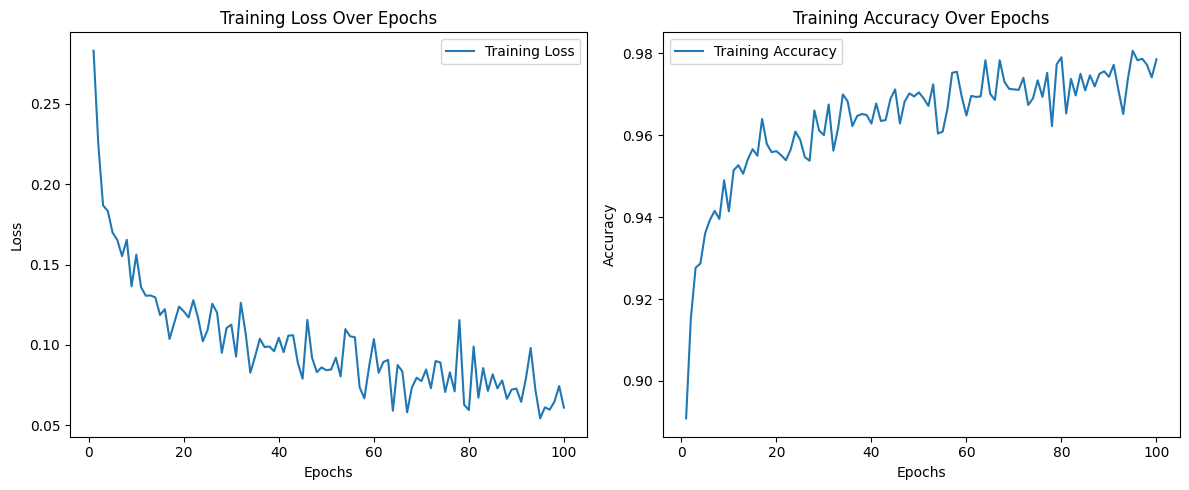

In [27]:
# Plotting the training loss and accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs_linear + 1), train_losses, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs_linear + 1), train_accuracies, label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Over Epochs')
plt.legend()

plt.tight_layout()
plt.show()


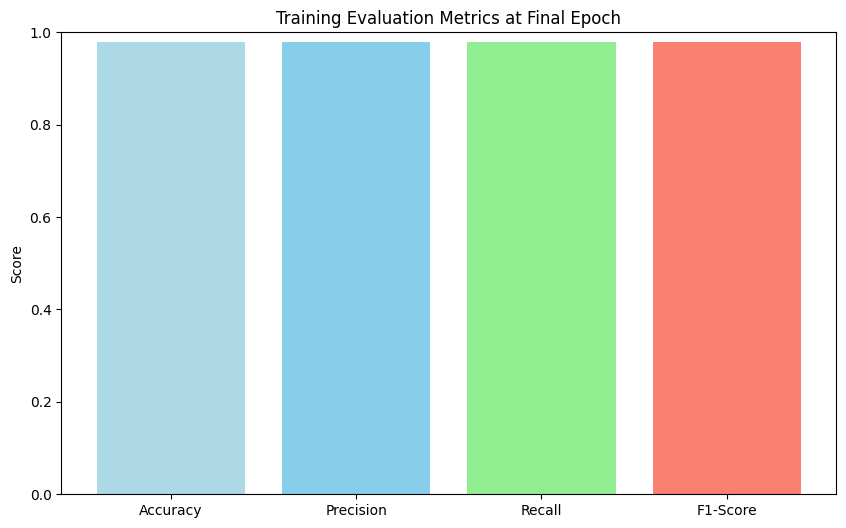

In [28]:
# Plotting accuracy, precision, recall, and F1-score
plt.figure(figsize=(10, 6))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']
scores = [train_accuracies[-1], train_precisions[-1], train_recalls[-1], train_f1_scores[-1]]  # Only plot the last epoch's values

# Plot the metrics
plt.bar(metrics, scores, color=['lightblue', 'skyblue', 'lightgreen', 'salmon'])
plt.ylabel('Score')
plt.ylim([0, 1])  # Assuming the metrics are normalized (between 0 and 1)
plt.title('Training Evaluation Metrics at Final Epoch')

plt.show()
